In [3]:
import numpy as np
import os
import stompy.model.delft.dflow_model as dfm
from stompy import utils
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib notebook

In [4]:
# 2016 runs
run_dirs=['data_2016long_3d_asbuilt_impaired-v001', # 50 layers no evap
          'data_short_v000', # has spikes, but not aligned with long run.
          'data_short_v001', # has spikes, aligned with short-v000
          # short_v002 has some spikes, but I'd like to know if the spikes are deterministic,
          # at least across restarts. 
           'data_3d_existing_impaired-v008',
           'data_3d_existing_impaired-v009',
         ]

In [5]:
models=[ dfm.DFlowModel.load(run_dir) for run_dir in run_dirs]

<IPython.core.display.Javascript object>


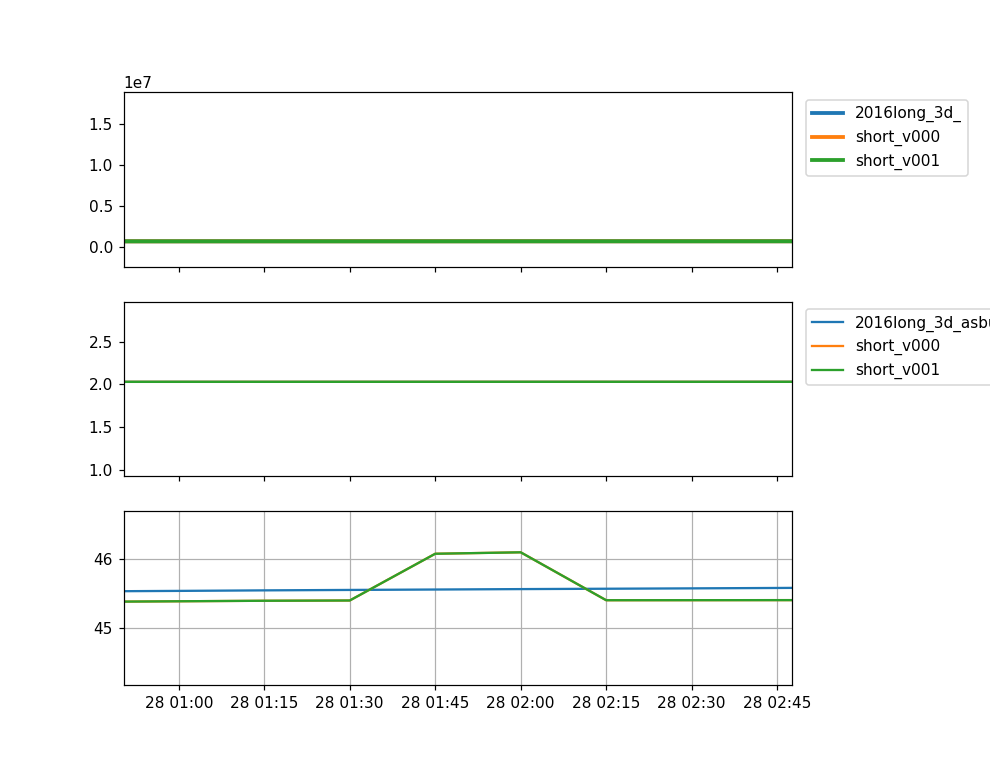

node_coordinates cross_section_geom_node_coordx cross_section_geom_node_coordy do not exist


/home/rustyh/miniconda3/envs/general/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


node_coordinates cross_section_geom_node_coordx cross_section_geom_node_coordy do not exist


/home/rustyh/miniconda3/envs/general/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


node_coordinates cross_section_geom_node_coordx cross_section_geom_node_coordy do not exist


/home/rustyh/miniconda3/envs/general/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [10]:
fig,axs=plt.subplots(3,1,sharex=True,figsize=[9,7])

labels=[mod.run_dir for mod in models]
labels=utils.distinct_substrings(labels)

t_ref=np.datetime64("2016-08-20 00:00")

for mod,label in zip(models,labels):
    his_ds=mod.his_dataset(refresh=True)
    
    Qsalt=his_ds['cross_section_cumulative_salt'].sel(cross_section='pesca_mid_xs')
    flux_ini=Qsalt.sel(time=t_ref,method='nearest').values
    salt_flux=Qsalt.values - flux_ini
    if np.isnan(salt_flux[-1]):
        label="NAN"+label
    axs[0].plot(Qsalt.time, salt_flux,
                label=label[:12],lw=2.5)
    axs[1].plot(his_ds.time, his_ds['waterlevel'].sel(stations='pc3'),label=label)
    axs[0].text(Qsalt.time.values[-1],
                np.random.random() + salt_flux[-1],label) # hard to see overlapping lines
    
    salt_max=his_ds.salinity.max(dim='stations').max(dim='laydim')
    axs[2].plot(his_ds.time,
                salt_max,
                label=label[:12])
    
axs[0].legend(loc='upper left',bbox_to_anchor=[1.01,1])
axs[1].legend(loc='upper left',bbox_to_anchor=[1.01,1])
fig.subplots_adjust(right=0.8)
# When the tide is rising, salt flux is going down.
# That means positive flux is downstream.

In [12]:
salt_max=his_ds.salinity.max(dim='stations').max(dim='laydim')

/home/rustyh/miniconda3/envs/general/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [14]:
ti=np.searchsorted(his_ds.time.values,np.datetime64("2016-08-28 01:45"))
salt_max.values[ti] # that's it.

salt=his_ds.salinity.isel(time=ti)

np.where(salt==salt_max.values[ti]) # 86, 24

(array([86]), array([24]))

<IPython.core.display.Javascript object>


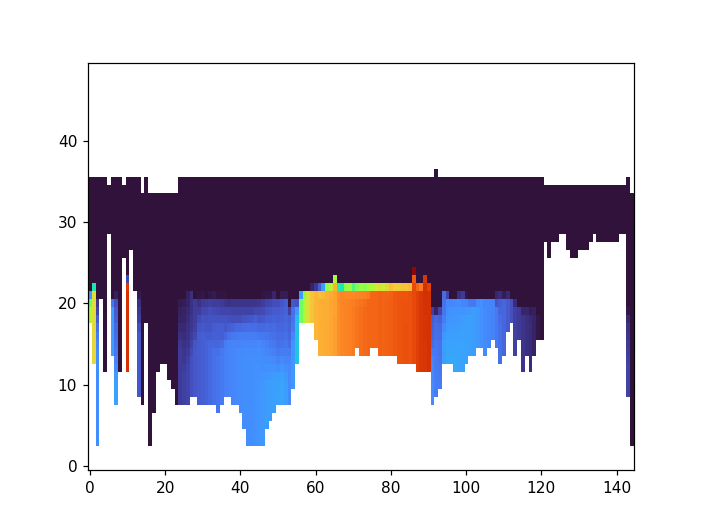

In [17]:
plt.figure()
img=plt.imshow(salt.T,aspect='auto',cmap='turbo',origin='lower')
img.set_clim([40,46.2])
# a highest value at the pycnocline -- like the huge gradients
# are generating salt, mostly at the upstream end?

<IPython.core.display.Javascript object>


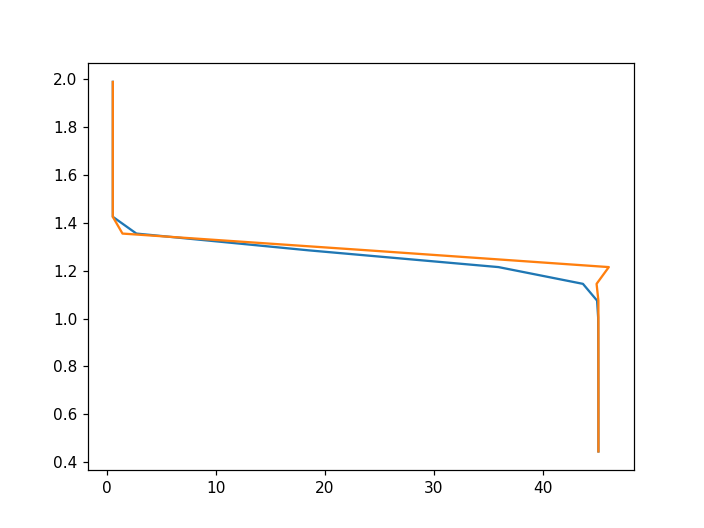

In [25]:
# Closer look at the offender:
plt.figure()
stn=86
for i in [ti-1,ti]:
    stn_ds=his_ds.isel(stations=stn,time=i)
    z=stn_ds.zcoordinate_c
    s=stn_ds.salinity
    plt.plot(s,z)

In [27]:
def bottom(da):
    # assumes data array is other,layer
    scal=da.values
    valid=np.isfinite(scal)
    # index of the *first* True in each column
    bed_idxs=np.argmax(valid,axis=1)
    return np.take_along_axis(scal,bed_idxs[:,None],axis=1)[:,0] 

In [39]:
ti

775

<IPython.core.display.Javascript object>


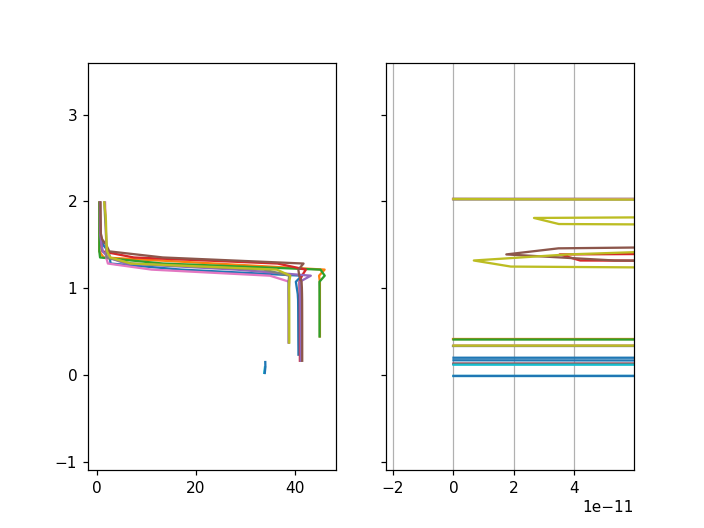

In [49]:
# find other profiles with unstable stratification
fig,axs=plt.subplots(1,2,sharey=True)

for i in range(770,820): #i=ti
    salt=his_ds.salinity.isel(time=i)
    # salt ~ [station, layer]
    bed_salt=bottom(salt)
    max_salt=salt.max(dim='laydim')
    dsalt=max_salt-bed_salt

    # at 1e-4, most of these look like the instability happened some time 
    # ago and is partially mixed down.
    for stn in np.nonzero(dsalt.values>1e-1)[0]:
        stn_ds=his_ds.isel(stations=stn,time=i)
        z=his_ds.zcoordinate_c.isel(stations=stn,time=i)
        s=his_ds.salinity.isel(stations=stn,time=i)
        axs[0].plot(s,z)
        zw=his_ds.zcoordinate_w.isel(stations=stn,time=i)
        #tke=his_ds.tke.isel(stations=stn,time=i)
        #axs[1].plot(np.log10(tke),zw)
        #vicww=his_ds.vicww.isel(stations=stn,time=i)
        #axs[1].plot(vicww,zw)
                

In [48]:
his_ds.vicww

<xarray.DataArray 'vicww' (time: 961, stations: 145, laydimw: 51)>
[7106595 values with dtype=float64]
Coordinates:
    station_x_coordinate  (stations) float64 ...
    station_y_coordinate  (stations) float64 ...
    station_name          (stations) |S256 b'pch_up                                                                                                                                                                                                                                                          ' ... b'seepageB                                                                                                                                                                                                                                                        '
    zcoordinate_w         (time, stations, laydimw) float64 ...
    zcoordinate_wu        (time, stations, laydimw) float64 ...
  * time                  (time) datetime64[ns] 2016-08-20 ... 2016-08-30
  * stations     

Mass Balance
--

In [4]:
his_ds=models[-1].his_dataset()

Some lines are degenerate


In [5]:
map_ds=models[-1].map_dataset()

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


In [7]:
map_ds.dss[0]

<xarray.Dataset>
Dimensions:                      (Two: 2, mesh2d_nEdges: 5098, mesh2d_nFaces: 3192, mesh2d_nInterfaces: 51, mesh2d_nLayers: 50, mesh2d_nMax_face_nodes: 4, mesh2d_nNodes: 1907, time: 7)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 5.53e+05 ... 5.532e+05
    mesh2d_node_y                (mesh2d_nNodes) float64 4.124e+06 ... 4.124e+06
    mesh2d_edge_x                (mesh2d_nEdges) float64 ...
    mesh2d_edge_y                (mesh2d_nEdges) float64 ...
    mesh2d_face_x                (mesh2d_nFaces) float64 5.53e+05 ... 5.532e+05
    mesh2d_face_y                (mesh2d_nFaces) float64 4.124e+06 ... 4.124e+06
    mesh2d_layer_z               (mesh2d_nLayers) float64 ...
  * time                         (time) datetime64[ns] 2016-08-21 ... 2016-08-24
Dimensions without coordinates: Two, mesh2d_nEdges, mesh2d_nFaces, mesh2d_nInterfaces, mesh2d_nLayers, mesh2d_nMax_face_nodes, mesh2d_nNodes
Data variables:
    projected_coordinate_system  int32 ..

In [7]:
his_ds['cross_section_cumulative_salt'].sel(cross_section='ocean_xs')

<xarray.DataArray 'cross_section_cumulative_salt' (time: 16)>
array([     0.      , 741835.331539, 762755.24241 , 778430.052247,
       792073.594265, 804487.250263, 814738.729677, 820946.732536,
       821910.469036, 815742.732664, 803821.324378, 786331.316541,
       764791.812815, 738716.472778, 705330.195154, 667669.44007 ])
Coordinates:
    cross_section_name  |S256 b'ocean_xs                                                                                                                                                                                                                                                        '
  * time                (time) datetime64[ns] 2016-08-21 ... 2016-08-21T03:45:00
    cross_section       <U16 'ocean_xs'
Attributes:
    long_name:  cumulative flux (based on upwind flow cell) for salt.
    units:      -
    geometry:   cross_section_geom

In [6]:
import pandas as pd

balances=[]

for model in models:
    bal_fn=os.path.join(model.run_dir,'DFM_OUTPUT_flowfm/flowfm_0000_mass_balances.csv')
    df=pd.read_csv(bal_fn,parse_dates=['datetimestart','datetimestop'])
    balances.append(df)

FileNotFoundError: [Errno 2] File b'data_2016long_3d_asbuilt_impaired-v001/DFM_OUTPUT_flowfm/flowfm_0000_mass_balances.csv' does not exist: b'data_2016long_3d_asbuilt_impaired-v001/DFM_OUTPUT_flowfm/flowfm_0000_mass_balances.csv'

In [21]:
df.dtypes

datetimestart        datetime64[ns]
datetimestop         datetime64[ns]
Mass Balance Area            object
Constituent                  object
Balance Term Type            object
Balance Term Name            object
In                          float64
Out                         float64
Nett                        float64
dtype: object

In [24]:
t_start=np.datetime64('2016-08-21 00:00')
sel=df.datetimestart==t_start
sel &= df['Mass Balance Area']=='Whole model'
sel &= df['Constituent']=='salt'
df[sel].Nett.sum() # This gets back to the mass balance error (flipped sign).

2.611448492971249